In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

# Week 13, ASTR 596: Fundamentals of Data Science


## More clustering, Density Estimation

### Gautham Narayan 
##### <gsn@illinois.edu>

## Project Proposals due today

I've got preliminary pitches from all 4 teams - some of you are tasked with defining the problem a bit more clearly

## Recap

- ML is broadly divided into supervised and unsupervised methods
- Supervised = you've got labels for the data you are trying to predict, unsupervised = you don't 

- Unsupervised methods then are about finding structure in the data itself
    - clustering is trying to find group similar samples in your dataset
    - you need some measure of distance to define similarity - a **metric**
    
- To effectively use clustering algorithms, you have to limit the number of dimensions or your metric isn't useful
    - viewed as an optimization problem, clustering (like all problems) gets hard to solve as the number of dimensions gets large
    - viewed as a density problem, as the number of dimensions gets large, the fractional volume within some hypersphere becomes 0 
        - i.e. your cluster isn't likely to enclose many points, because as the dimensionality grows, samples themselves are spread further apart

- To tackle this we use **dimensionality reduction** 
    - **Principal Component Analysis** - express your data as a sum of orthogonal eigenvectors constructed such that (hopefully) a few eigenvectors explain most of the variance of the data
        - linear methods don't necessarily work well for non-linear structure in the data but are invertible
    - ```astronomers will often try to derive physical insight from PCA eigenspectra or eigentimeseries, but this is not advisable as there is no physical reason for the data to be linearly and orthogonally separable``` - snark from Adam Miller (Northwestern)
    - there are non-linear methods - manifold learning (i.e. IsoMaps)/LLE/autoencoders and variants  

- Once you have some reasonably low-dimensional representation of your data:    
        - k-means: splits dataset into $k \sim$ approximately equally sized clusters by finding the mean cluster centers using MSE as a metric
        - GMMs: splits dataset into a sum of $k$ Gaussians (you don't have to use Gaussians but the likelihood/metric is easy)
- in both cases, for each sample in the dataset, we're creating a latent variable which encodes cluster membership 
- clustering can be viewed as a hierarchical model where the cluster parameters specify the population


- **Expectation Maximiation** - hold cluster membership fixed, update population parameters, then hold population parameters fixed and update cluster membership 

## Clustering isn't just finding groups of things that are similar

What you are doing is specifying a **parametric** model for the **density of the data** 

This is usually a better use for clustering algorithms - the cluster centers and sizes may not be useful/physically meaningful, but the sum of all the components is a representation of the underlying density field reconstructed from sparse samples:

Our Universe is only isotropic and homogenous on the largest scales - when you smooth over filaments in the cosmic web:

<img src="galaxy_map.gif" width="70%">

## Demo: The use of GMMs as a tool for density estimation

- We'll use the Sloan Dataset to estimate density with k=50 and k=200 GMMs
- Look at how clusters in the data (i.e. look at your data and identify these by eye) map to centers of Gaussians
- And look at how the GMM traces the overall density

In [2]:
from sklearn.mixture import GaussianMixture
from astroML.datasets import fetch_great_wall
from astroML.utils.decorators import pickle_results
from sklearn.neighbors import KernelDensity

In [3]:
# load great wall data
X = fetch_great_wall()


def compute_GMM(n_clusters, max_iter=1000, tol=3, covariance_type='full'):
    clf = GaussianMixture(n_clusters, covariance_type=covariance_type,
                          max_iter=max_iter, tol=tol, random_state=0)
    clf.fit(X)
    return clf

#------------------------------------------------------------
# Compute a grid on which to evaluate the result
Nx = 100
Ny = 250
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

clf1 = compute_GMM(n_clusters=50)
clf2 = compute_GMM(n_clusters=200)
log_dens1 = clf1.score_samples(Xgrid).reshape(Ny, Nx)
log_dens2 = clf2.score_samples(Xgrid).reshape(Ny, Nx)

/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


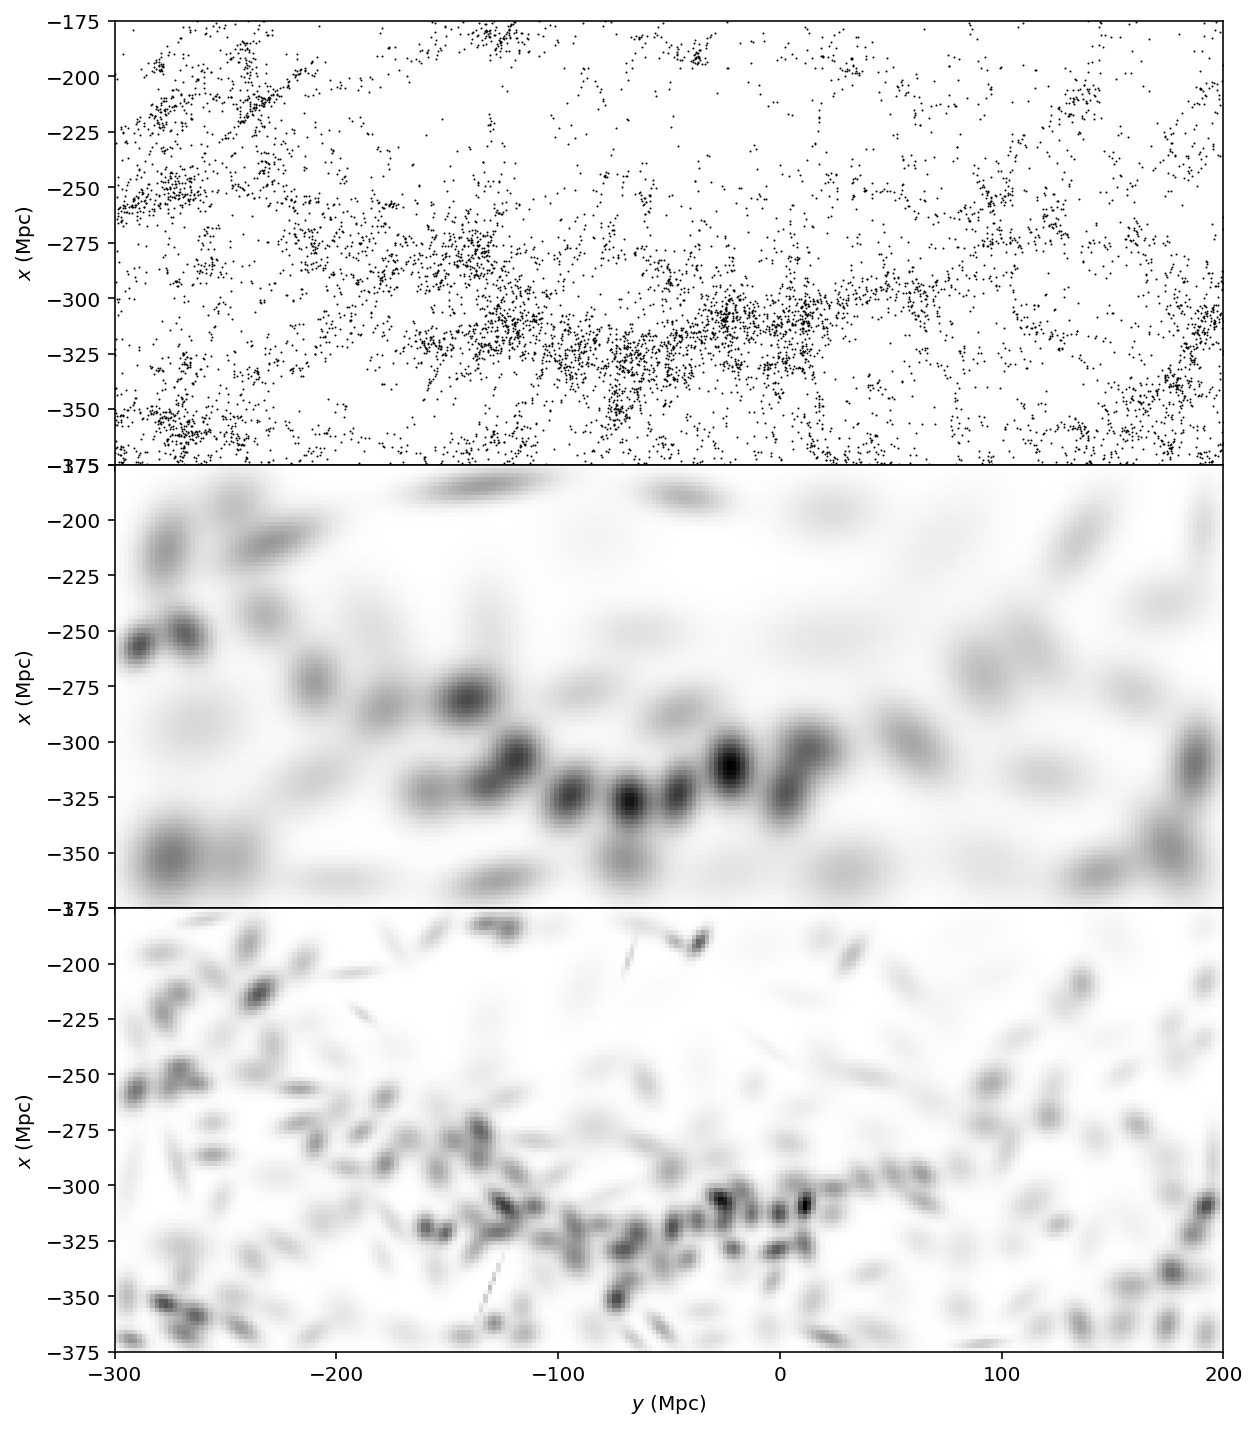

In [4]:
# Plot the results
fig = plt.figure(figsize=(10, 12))
fig.subplots_adjust(hspace=0, left=0.08, right=0.95, bottom=0.13, top=0.9)

ax = fig.add_subplot(311, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)

ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.ylabel(r'$x\ {\rm (Mpc)}$')

ax = fig.add_subplot(312, aspect='equal')
ax.imshow(np.exp(log_dens1.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel(r'$x\ {\rm (Mpc)}$')

ax = fig.add_subplot(313, aspect='equal')
ax.imshow(np.exp(log_dens2.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])
ax.set_xlabel(r'$y\ {\rm (Mpc)}$')
ax.set_ylabel(r'$x\ {\rm (Mpc)}$')

plt.show()

## KDEs

Mixture models are really useful for estimating density (you can still use them for clustering, but you've got to work to interpret what the clusters are and how many you need)

While a mixture model is parametric, you can take the extreme limit of making the number of clusters = the number of datapoints, and instead of treating the mean as a parameter, use the value of the data itself as the mean. 

To simplify things further, we'll assume all the components of the mixture have the same scale/$\sigma$ or more generally a **bandwidth** - which you specify 

This is called **kernel density estimation** 

A common kernel is the (YOU GUESSED IT) Gaussian kernel that we just used above:

$$K(u) = \frac{1}{(2\pi)^{D/2}}\exp^{-u^2/2}$$


Once a kernel is chosen the kernel density estimate at a given point, $x$, is given by 

$$ \rho(x) = \frac{1}{Nh^D}\sum_{i=1}^N K\left(\frac{d(x,x_i)}{h}\right),$$ where $\rho(x)$ is an estimator of our distribution.

## Where does this come from? 

If you wanted to know the density of points you could compute 

$$\frac{\sum_1^N\delta (x-x_i)}{V}$$ 

where $\delta (x-x_i)$ is the Delta function, $V$ is the volume, and $N$ is the number of points. 

In $D$-dimensional space a volume element is just $h^D$. Then instead of representing our observation as a delta function, we represent it by our kernel function. To normalize for the number of points, divide by $N$.

The argument of $K$ is just some measure of the distance between $x$ and each $x_i$. 

Normally $d(x,x_i) = (x-x_i)$. For the gaussian kernel that makes $h=\sigma$.

In [5]:
# CHANGE PARAMETERS FOR KERNEL, METRIX AND BANDWIDTH AS YOU LIKE
kde = KernelDensity(bandwidth=5, kernel='gaussian', metric='euclidean')
kde.fit(X)
log_dens3 = kde.score_samples(Xgrid).reshape(Ny, Nx)

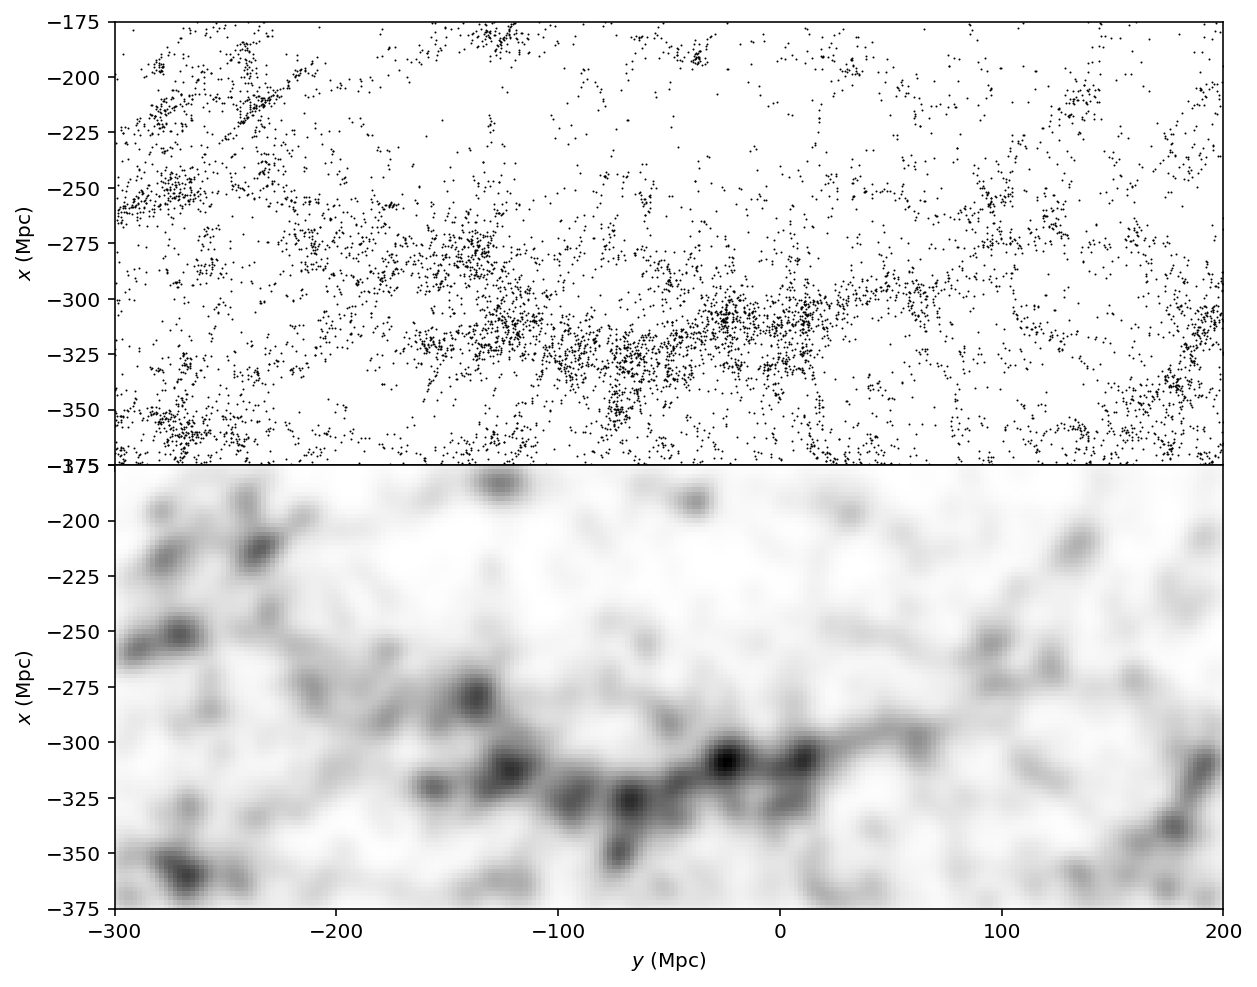

In [6]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0, left=0.08, right=0.95, bottom=0.13, top=0.9)

ax = fig.add_subplot(211, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)

ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.ylabel(r'$x\ {\rm (Mpc)}$')

ax = fig.add_subplot(212, aspect='equal')
ax.imshow(np.exp(log_dens3.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])


ax.set_xlabel(r'$y\ {\rm (Mpc)}$')
ax.set_ylabel(r'$x\ {\rm (Mpc)}$')

plt.show()

You can view this as a **convolution** operation - just as with the 2D PSF and single source, you are convolving each point with a kernel (shape, metric and bandwidth is what you specify) 

You then sum up all the kernels and get a model for the underlying density field - just as with a GMM. 

The distinction is that with GMMs you were specifying a parametric model for the **population**

Here, *just as with the kernel in Gaussian Processes* you are specifying how points are correlated with each other in the density field.

And just as with Gaussian processes, you've got several potential choices for kernels. Common ones are below:

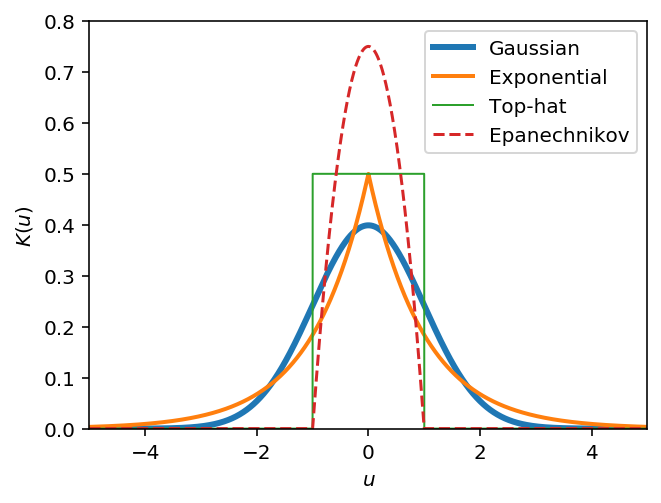

In [7]:
import numpy as np
from matplotlib import pyplot as plt

#------------------------------------------------------------
# Compute Kernels.
u = np.linspace(-5, 5, 10000)
du = u[1] - u[0]

gauss = (1. / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u ** 2)

exp = 0.5 * np.exp(-abs(u))

tophat = 0.5 * np.ones_like(u)
tophat[abs(u) > 1] = 0 # Range of the tophat kernel

ep = (3/4.)*(1-u**2)  
ep[abs(u)>1]=0 # Set the range of the Epanechnikov kernel

#------------------------------------------------------------
# Plot the kernels
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

ax.plot(u, gauss, '-', c='C0', lw=3, label='Gaussian')
ax.plot(u, exp, '-', c='C1', lw=2, label='Exponential')
ax.plot(u, tophat, '-', c='C2', lw=1, label='Top-hat')
ax.plot(u,ep,'--',c='C3',label='Epanechnikov')  
ax.legend(loc=1)

ax.set_xlabel('$u$')
ax.set_ylabel('$K(u)$')

ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.8001)
plt.show()

Nonparametric density estimation is useful when we know nothing about the underlying population distribution of the data since we don't have to specify a model (again, just as in Gaussian processes).

This flexibility allows us to capture the shape of the distribution well, at the expense of more difficulty interpreting the results.

## Why should I care about density estimates anyway and what has this got to do with machine learning???

You can draw new samples from density fields - i.e. you can simulate new data given a density estimate constructed on other data - i.e. you can use if for **data augmentation**

Also note that PDFs are just density fields - you can use KDEs to get smooth representations of the underlying PDF (you've already done this multiple times this semester) - and you know that sampling PDFs is sorta useful...

## But why go through all this - can't I just histogram the data to get an estimate of the density???

Sure, histograms are useful, but they're also risky - look at what happens when we adjust bins below:

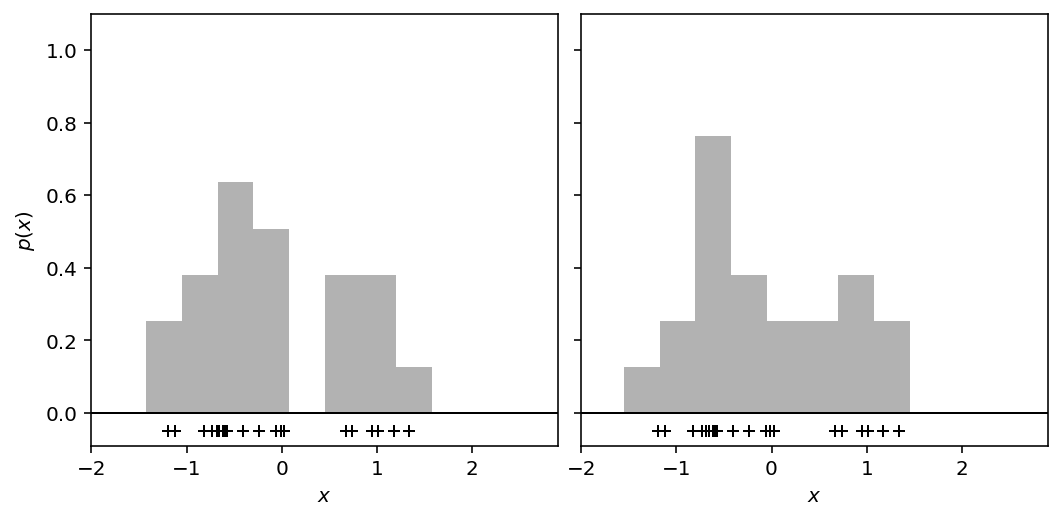

In [8]:
# Draw the random data
np.random.seed(1)
x = np.concatenate([np.random.normal(-0.5, 0.3, size=14), np.random.normal(1, 0.3, size=7)])


# First figure: silly histogram binning
fig1 = plt.figure(figsize=(8, 4))
fig1.subplots_adjust(left=0.12, right=0.95, wspace=0.05, bottom=0.15, top=0.9, hspace=0.05)


XLIM = (-2, 2.9)
YLIM = (-0.09, 1.1)

ax = fig1.add_subplot(121)
bins = np.linspace(-1.8, 2.7, 13)
ax.hist(x, bins=bins, density=True, histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

#Shift bin centers by 0.25
ax = fig1.add_subplot(122)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.hist(x, bins=bins + 0.25, density=True, histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')

plt.show()


The underlying distribution in both panels is the same, that is the data points that make up the histogram are the same. All we have done is shifted the locations of the bins by 0.25.

KDEs take away one of the issues - where the bins are - but you still are left with how to choose the bandwidth for the KDE (analogous to chosing the bin-width for the histogram) and you have a new issue - how to choose the kernel

Text(0.5, 0, '$x$')

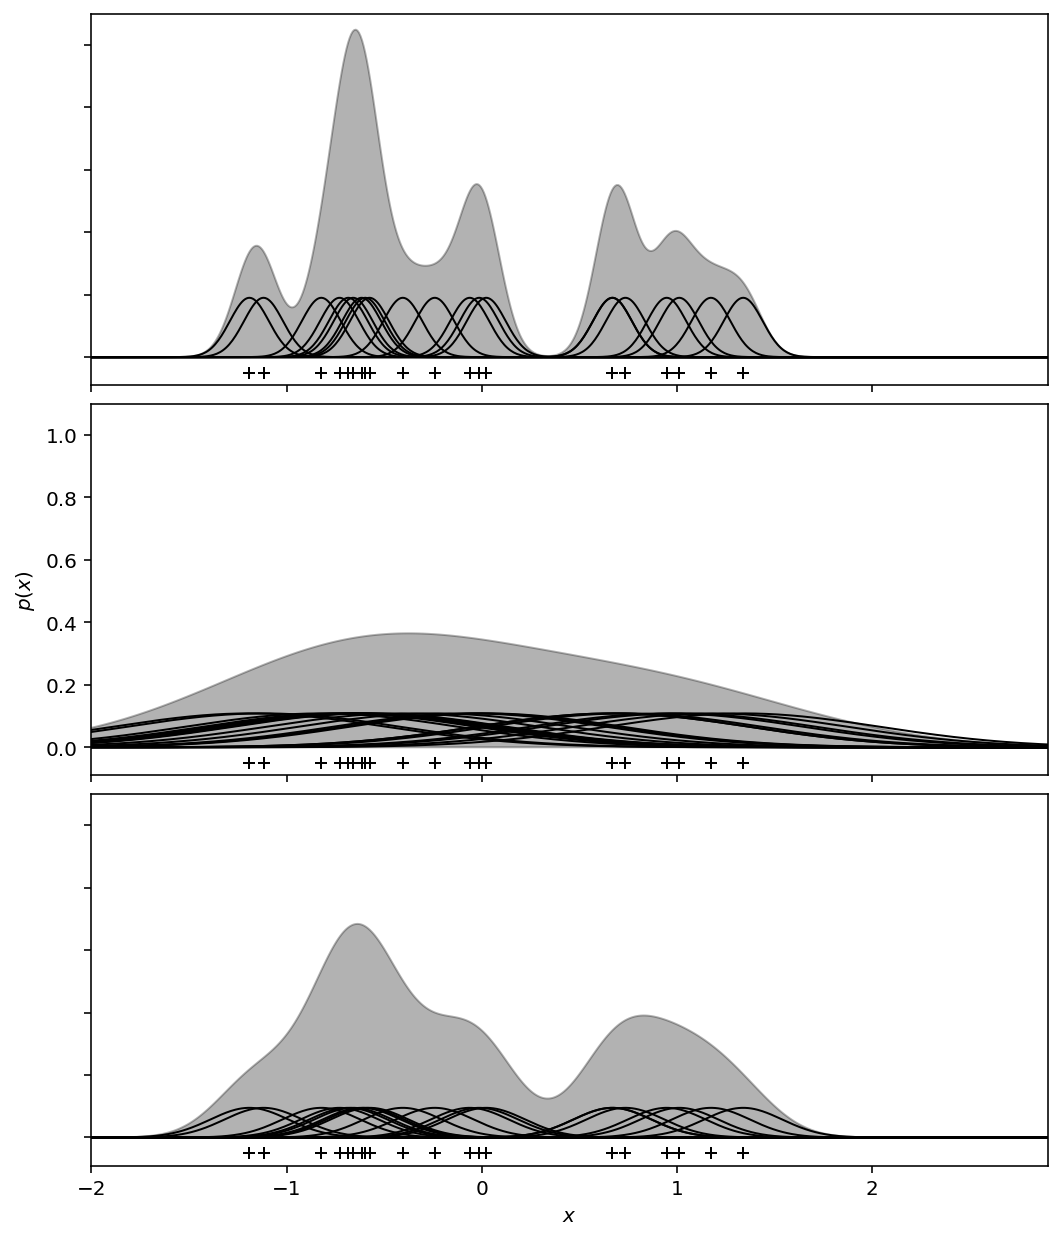

In [9]:
from scipy import stats
fig2 = plt.figure(figsize=(8, 8))
fig2.subplots_adjust(left=0.12, right=0.95, wspace=0.05, bottom=0.0, top=1.0, hspace=0.05)

ax = fig2.add_subplot(311)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.1)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)

ax = fig2.add_subplot(312)
ax.xaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.7)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, 4 * y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_ylabel('$p(x)$')
ax.set_xlabel('$x$')

ax = fig2.add_subplot(313)
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.2)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')

This looks better, but gives us a "Goldilocks" problem. The first plot uses a kernel that is too narrow. The second is too wide. The third is "just right".

#### The crucial part of KDE is to determine the optimal value for the width of the kernel.

We can empirically determine the optimal bandwidth through **cross validation** 

## Cross-Validation

Cross validation is related to the construction of training and test sets that we talked about last time (see week 11). Except now we're using the same idea in the context of unsupervised learning (and you can use it for for all of the first half of the semester, not just ML)

There are a number of different ways to do **cross-validation**. For example, you could randomly sample to decide which data goes into the training or test sets: 

<img src="http://i.stack.imgur.com/4Lrff.png" width="60%">

Where we aren't just doing this once, but rather many times so that each data point is treated both as a training point and as a test point.

We could do this in a more ordered way (e.g., to make sure that each point gets sampled as training/test the same number of times) and do a $K$-fold cross validation.  Here $K$ is the number of "experiments" that need to be done so that each data point appears in a test sample once.

<img src="http://i.stack.imgur.com/fhMza.png" width="60%">

We can take that to the extreme by having $K\equiv N$, so that in each experiment we leave out just one object.  This is called "Leave-One-Out" cross validation:

<img src="http://images.slideplayer.com/16/4977882/slides/slide_35.jpg" width="60%">

We can implement this in `sklearn` with `GridSearchCV` and replot our histogram:

In [10]:
# Complete and Execute this cell to determine the bandwidth

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
bwrange = np.linspace(0.1, 1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) 
grid.fit(x[:, None]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.1310344827586207


(-0.09, 1.1)

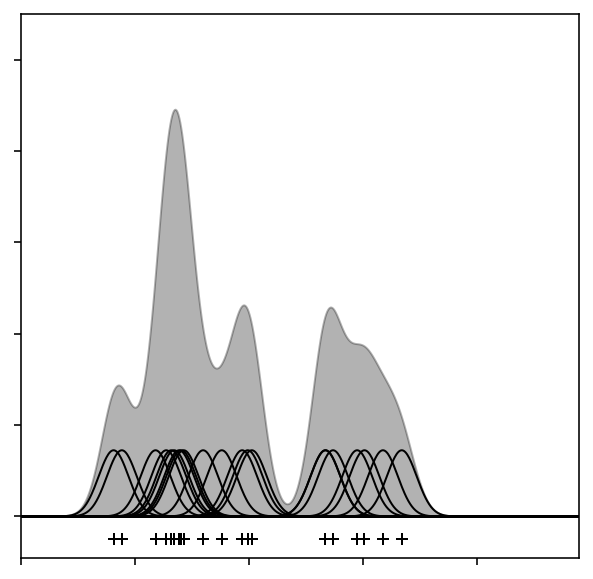

In [11]:
# Execute this cell to see the new "histogram"
fig2 = plt.figure(figsize=(5, 5))
ax = fig2.add_subplot(111)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], h_opt)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)

OK, so we've gone from $k$ clusters to replacing each data point with it's own kernel representing points in the underlying latent density field that are clustered with it. 

This was good for density estimation, but sometimes we do actually want clustering - grouping similar objects together. 

So it's reasonable to ask if this non-parametric density estimation technique can be converted back to clustering like we had with $k$-means and GMMs.

## Hierarchical Clustering

In Hierarchical Clustering, we don't specify the number of clusters ahead of time, we start with $N$ clusters representing each data point. 

Then the most similar clusters are joined together, the process repeating until some threshhold is reached.


<img src="Hierarchical-clustering-2.png">

Clusters are merged at each step according to which are "nearest" to each other---where the definition of nearest needs to be specified - i.e. you still need a **metric** and your output is going to depend on how you make this choice.

After selecting a distance metric, it is necessary to determine from **where** distance is computed. 
    - Can be computed between the two most similar parts of a cluster (single-linkage), 
    - the two least similar bits of a cluster (complete-linkage)
    - the center of the clusters (mean or average-linkage)
    ....

As with distance metrics, the choice of linkage criteria should be made based on domain knowledge. 

**What causes variation between groups**

The default is just reducing the sum of squared distances of each observation from the average observation in a cluster. 

Some threshhold needs to be specified to tell the process where to stop clustering - i.e. the usual bias variance tradeoff - you can grow your tree upwards to where all points are clustered, but this may not be useful.

The typical choice for distance (Euclidean) and linkage criterion (average) results in what is called a **"minimum spanning tree"** 

You can of course visualize this minimum spanning tree and the result is a **dendrogram** just as you saw with decision trees.

In [12]:
from scipy import sparse
from astroML.clustering import HierarchicalClustering, get_graph_segments

X = fetch_great_wall()

xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Compute the MST clustering model
n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=10,
                               edge_cutoff=edge_cutoff,
                               min_cluster_size=cluster_cutoff)
model.fit(X)
print(" scale: %2g Mpc" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff))

n_components = model.n_components_
labels = model.labels_



#------------------------------------------------------------
# Get the x, y coordinates of the beginning and end of each line segment
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

Nx = 100
Ny = 250
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T


total_dens = None



for i in range(n_components):
    ind = (labels == i)
    Npts = ind.sum()
    Nclusters = int(min(12, Npts / 5))
    clf = compute_GMM(n_clusters=Nclusters)
    log_dens = clf.score_samples(Xgrid).reshape(Ny, Nx)
    dens = np.exp(log_dens)
    if total_dens is None:
        total_dens = dens
    else:
        total_dens += dens


density = total_dens

 scale: 3.54953 Mpc


/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


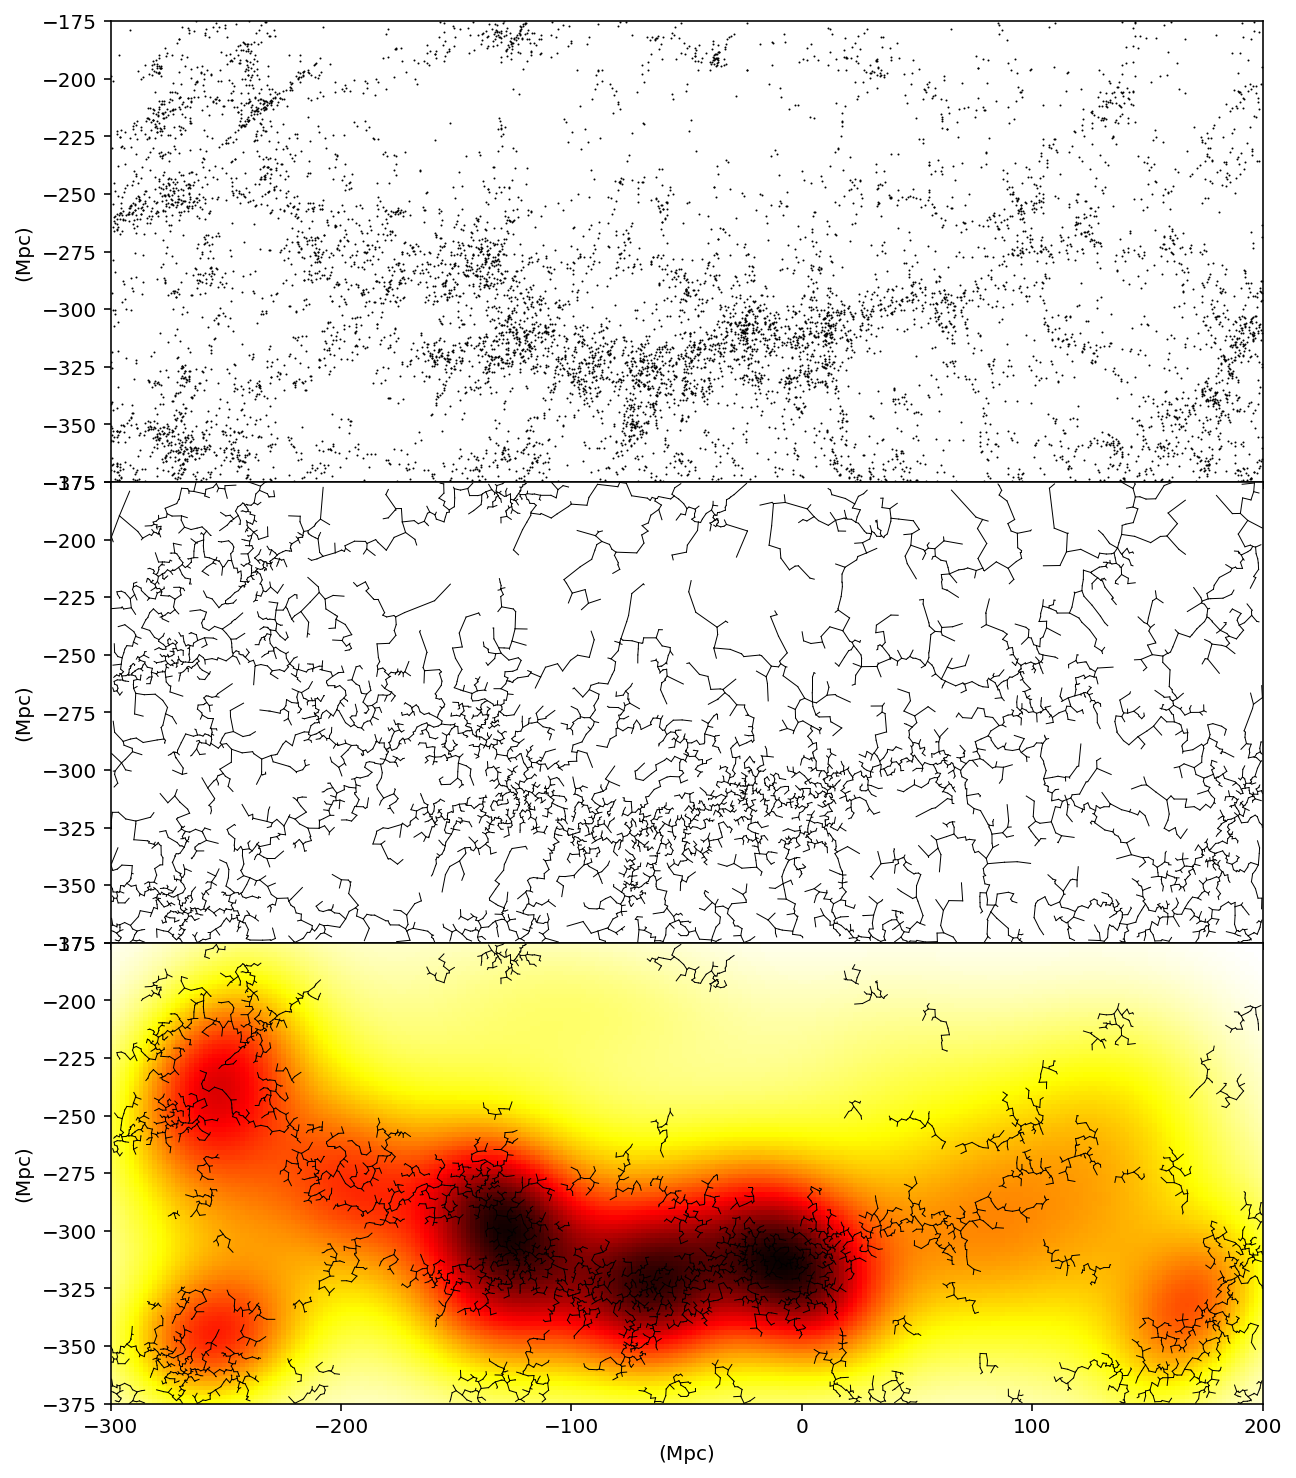

In [13]:
#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(312, aspect='equal')
ax.plot(T_y, T_x, c='k', lw=0.5)
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(313, aspect='equal')
ax.plot(T_trunc_y, T_trunc_x, c='k', lw=0.5)
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(Mpc)')
ax.set_ylabel('(Mpc)')

plt.show()